# Temperature and salinity anomalies

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [4]:
client = Client()
client

<Client: 'tcp://127.0.0.1:43415' processes=8 threads=48, memory=188.57 GiB>

In [5]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-59)

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

# Temperature maps averaged over years 11-15:
Note that this uses lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

In [69]:
# define plotting routine:
def plot_land_etc(control_variable,up_variable,down_variable,scale_max):
    fig  = plt.figure(1, figsize = (15,12))
    norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

    # up:
    # setup stereo projection:
    ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # plot:
    cf = ax.pcolormesh(control_variable.xt_ocean, control_variable.yt_ocean, up_variable-control_variable, norm = norm, 
                       cmap = cmocean.balance, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title(depth_string+' temperature, easterlies increase anomaly',fontsize=fontsize)
    ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
                 zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    
    # down:
    # setup stereo projection:
    ax = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # plot:
    cf = ax.pcolormesh(control_variable.xt_ocean, control_variable.yt_ocean, down_variable-control_variable, norm = norm, 
                       cmap = cmocean.balance, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title(depth_string+' temperature, easterlies decrease anomaly',fontsize=fontsize)
    ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
                 zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

    # colorbar:
    cbaxes = fig.add_axes([0.89, 0.55, 0.015, 0.4])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(r'Temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

## Surface maps

In [52]:
depth_slice = 0
depth_string = str(depth_slice)+'m'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con_slice = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_con_slice = temp_con_slice.load()

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up_slice = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_up_slice = temp_up_slice.load()

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down_slice = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_down_slice = temp_down_slice.load()

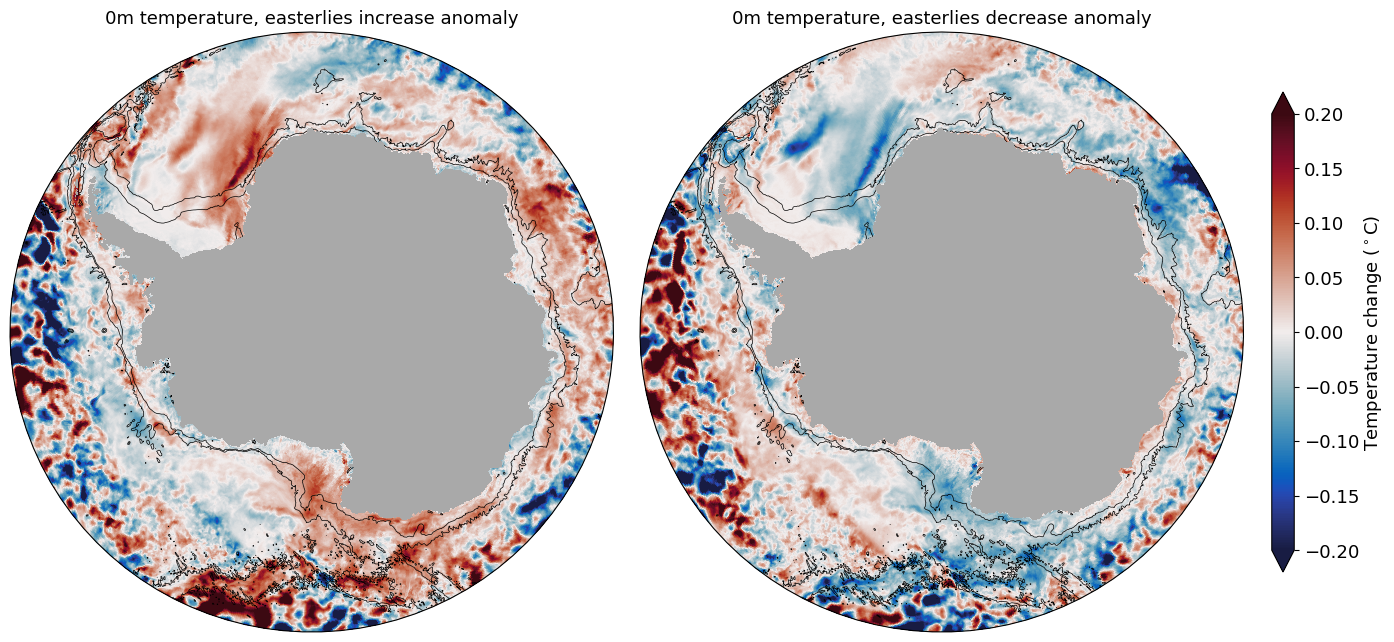

In [53]:
plot_land_etc(temp_con_slice,temp_up_slice,temp_down_slice,0.2)

## Surface map in first year

In [67]:
start_time='2150-01-01'
end_time='2150-12-31'

depth_slice = 0
depth_string = str(depth_slice)+'m'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con_slice = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_con_slice = temp_con_slice.load()

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up_slice = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_up_slice = temp_up_slice.load()

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down_slice = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_down_slice = temp_down_slice.load()

In [72]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
temp_con_slice = temp_con_slice * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_down_slice = temp_down_slice * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_up_slice = temp_up_slice * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

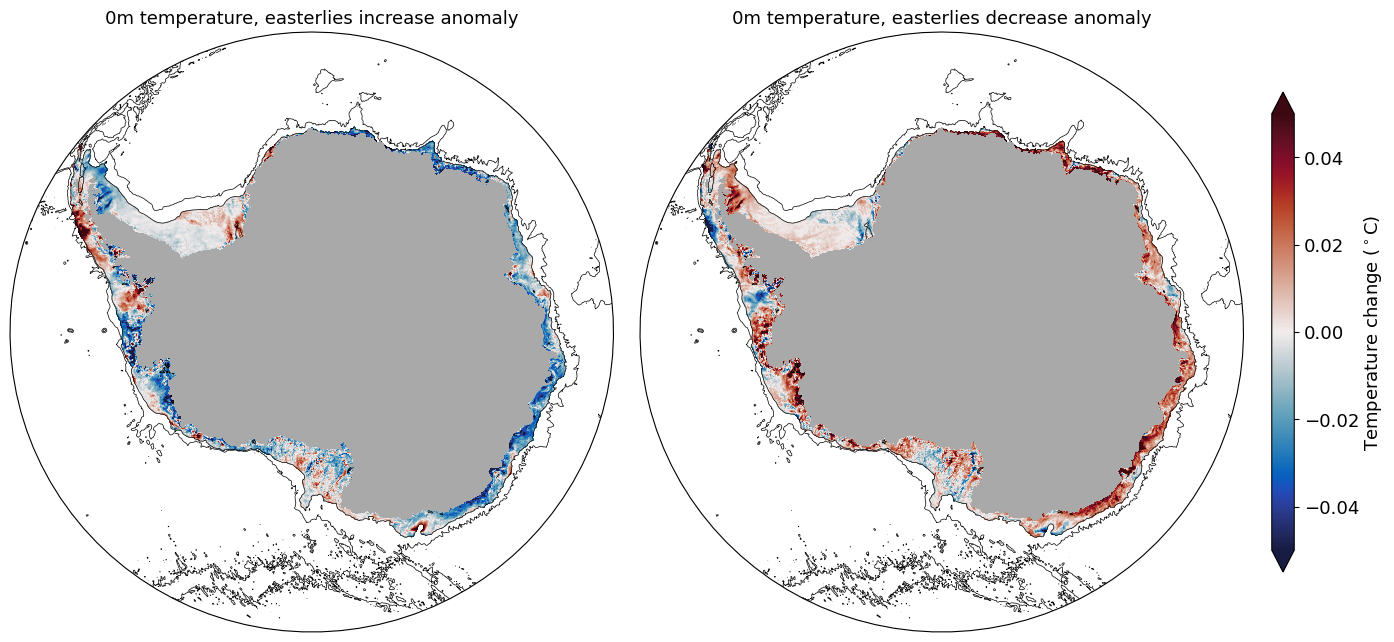

In [73]:
plot_land_etc(temp_con_slice,temp_up_slice,temp_down_slice,0.05)

## 200m maps

In [54]:
# go back to last 5 years:
start_time='2160-01-01'
end_time='2164-12-31'

depth_slice = 200
depth_string = str(depth_slice)+'m'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con_slice = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_con_slice = temp_con_slice.load()

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up_slice = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_up_slice = temp_up_slice.load()

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down_slice = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_down_slice = temp_down_slice.load()

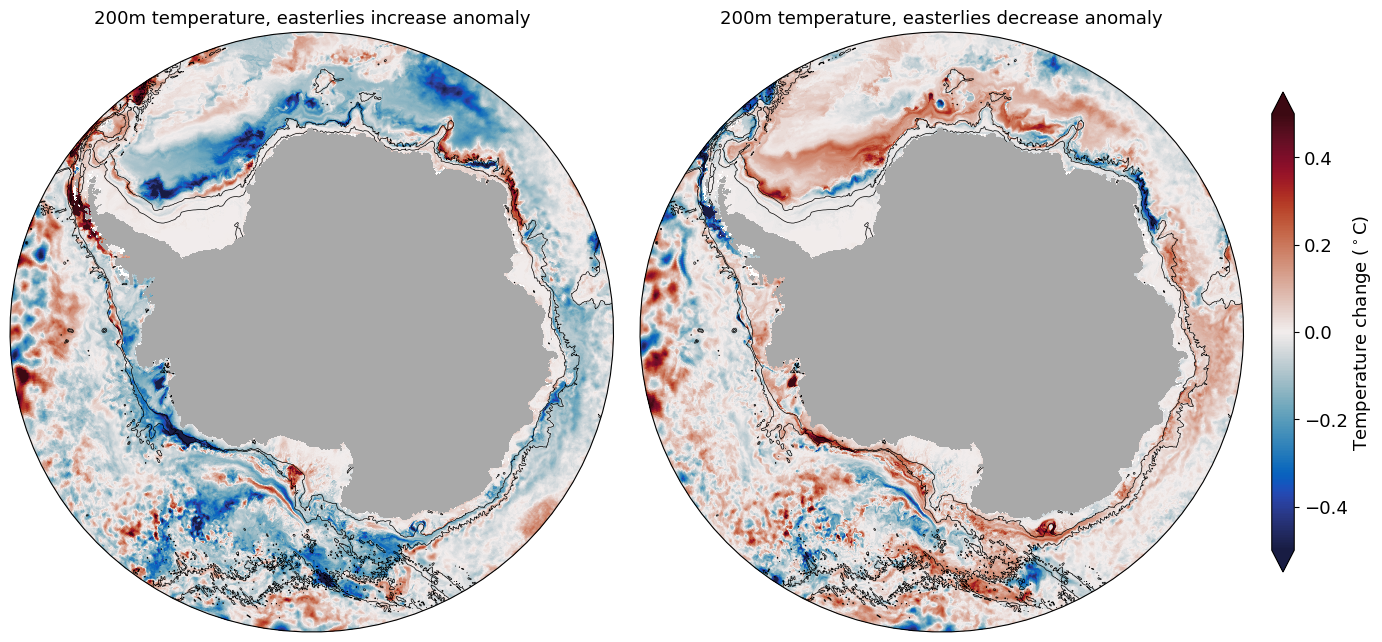

In [55]:
plot_land_etc(temp_con_slice,temp_up_slice,temp_down_slice,scale_max=0.5)

## 500m maps

In [60]:
depth_slice = 500
depth_string = str(depth_slice)+'m'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con_slice = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_con_slice = temp_con_slice.load()

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up_slice = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_up_slice = temp_up_slice.load()

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down_slice = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
temp_down_slice = temp_down_slice.load()

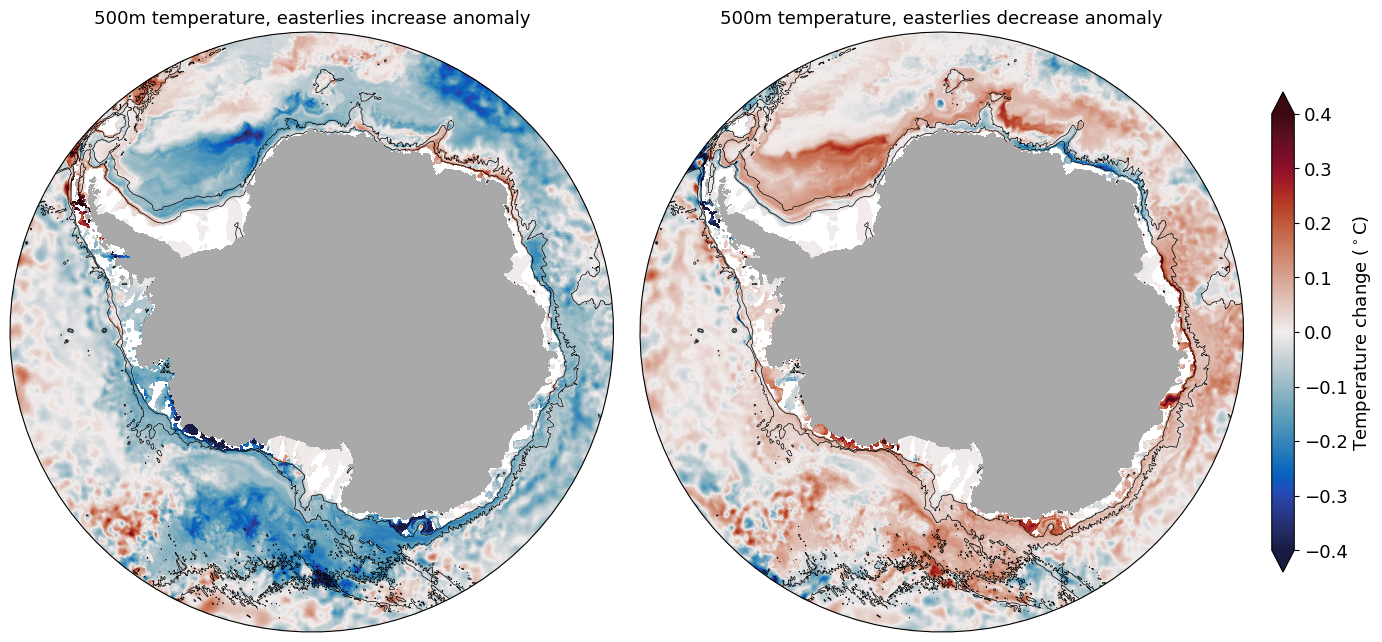

In [61]:
plot_land_etc(temp_con_slice,temp_up_slice,temp_down_slice,0.4)

## Bottom maps

In [58]:
depth_string = 'bottom'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_up = temp_up.where(depth_array.st_ocean >= max_depth)
bottom_temp_up = bottom_temp_up.sum(dim = 'st_ocean')
bottom_temp_up = bottom_temp_up.load()

bottom_temp_down = temp_down.where(depth_array.st_ocean >= max_depth)
bottom_temp_down = bottom_temp_down.sum(dim = 'st_ocean')
bottom_temp_down = bottom_temp_down.load()

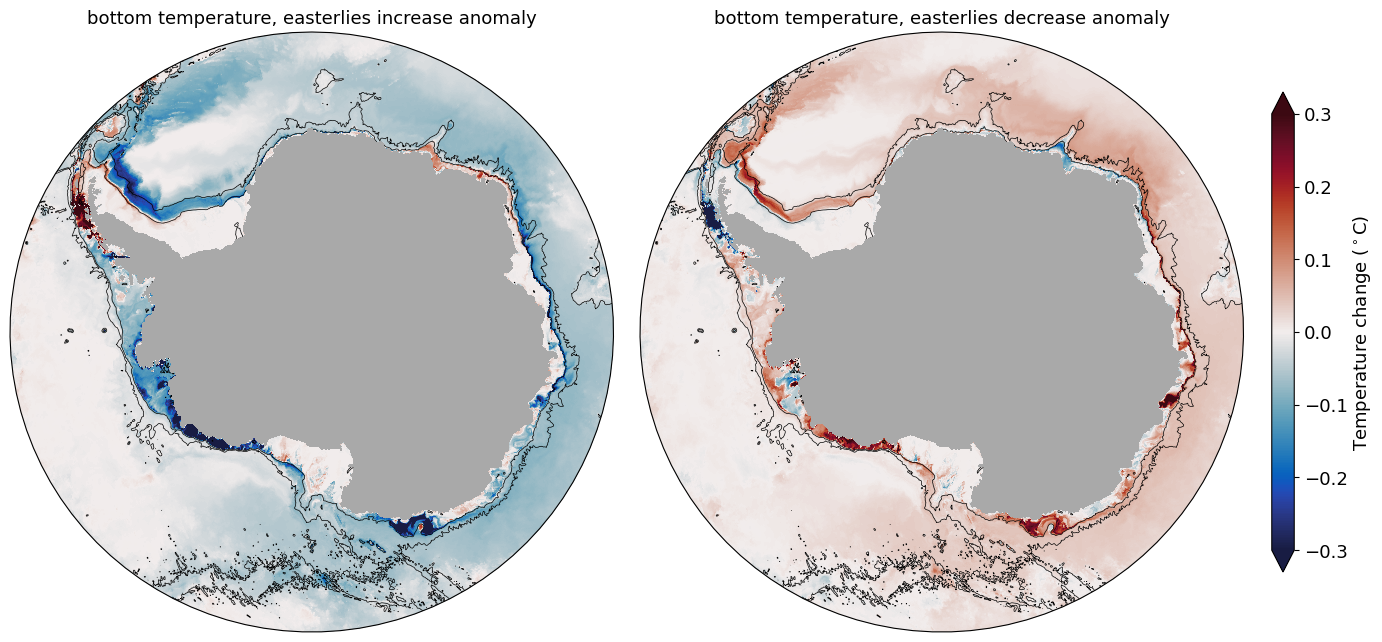

In [67]:
plot_land_etc(bottom_temp_con,bottom_temp_up,bottom_temp_down,0.3)

# Salinity maps averaged over years 11-15:
Note that this uses lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

In [68]:
# define plotting routine:
def plot_land_etc(control_variable,up_variable,down_variable,scale_max):
    fig  = plt.figure(1, figsize = (15,12))
    norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

    # up:
    # setup stereo projection:
    ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # plot:
    cf = ax.pcolormesh(control_variable.xt_ocean, control_variable.yt_ocean, up_variable-control_variable, norm = norm, 
                       cmap = cmocean.balance, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title(depth_string+' salinity, easterlies increase anomaly',fontsize=fontsize)
    ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
                 zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    
    # down:
    # setup stereo projection:
    ax = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # plot:
    cf = ax.pcolormesh(control_variable.xt_ocean, control_variable.yt_ocean, down_variable-control_variable, norm = norm, 
                       cmap = cmocean.balance, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title(depth_string+' salinity, easterlies decrease anomaly',fontsize=fontsize)
    ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
                 zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

    # colorbar:
    cbaxes = fig.add_axes([0.89, 0.55, 0.015, 0.4])
    cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(r'Salinity change',fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

## Surface maps

In [69]:
depth_slice = 0
depth_string = str(depth_slice)+'m'

salt_con = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con_slice = salt_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_con_slice = salt_con_slice.load()

salt_up = cc.querying.getvar(easterlies_up,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_up_slice = salt_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_up_slice = salt_up_slice.load()

salt_down = cc.querying.getvar(easterlies_down,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_down_slice = salt_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_down_slice = salt_down_slice.load()

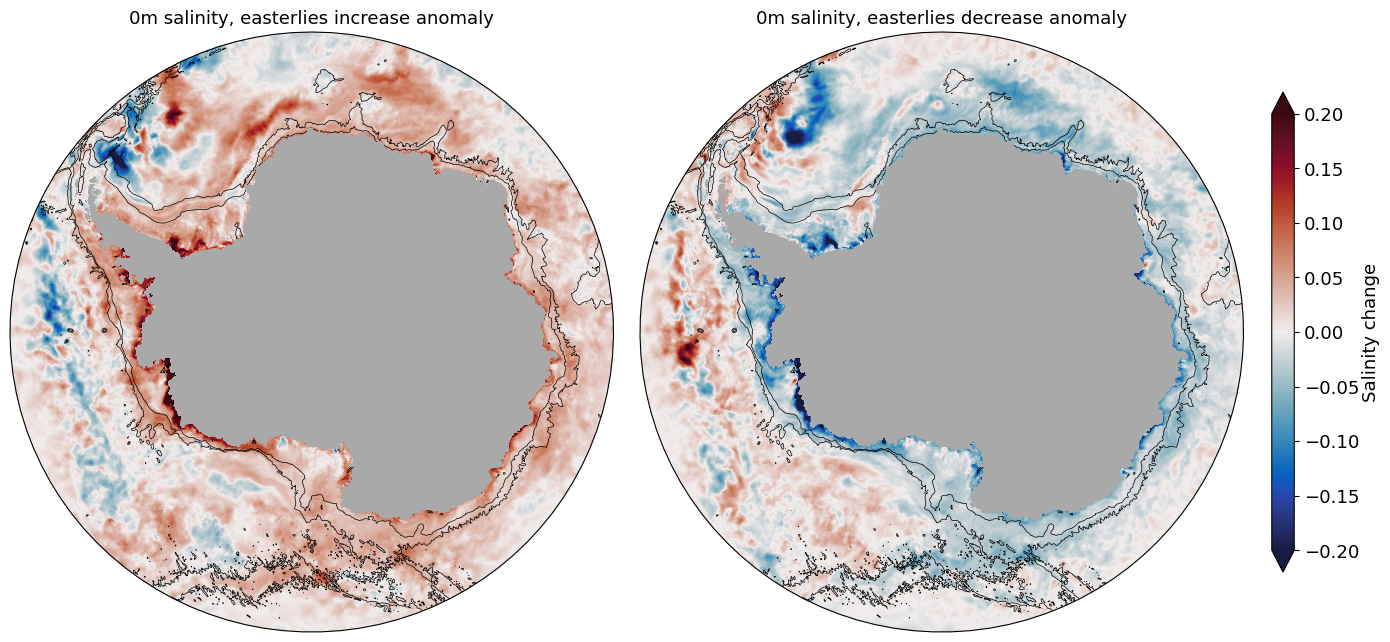

In [71]:
plot_land_etc(salt_con_slice,salt_up_slice,salt_down_slice,0.2)

## 200m maps

In [72]:
depth_slice = 200
depth_string = str(depth_slice)+'m'

salt_con = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con_slice = salt_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_con_slice = salt_con_slice.load()

salt_up = cc.querying.getvar(easterlies_up,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_up_slice = salt_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_up_slice = salt_up_slice.load()

salt_down = cc.querying.getvar(easterlies_down,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_down_slice = salt_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_down_slice = salt_down_slice.load()

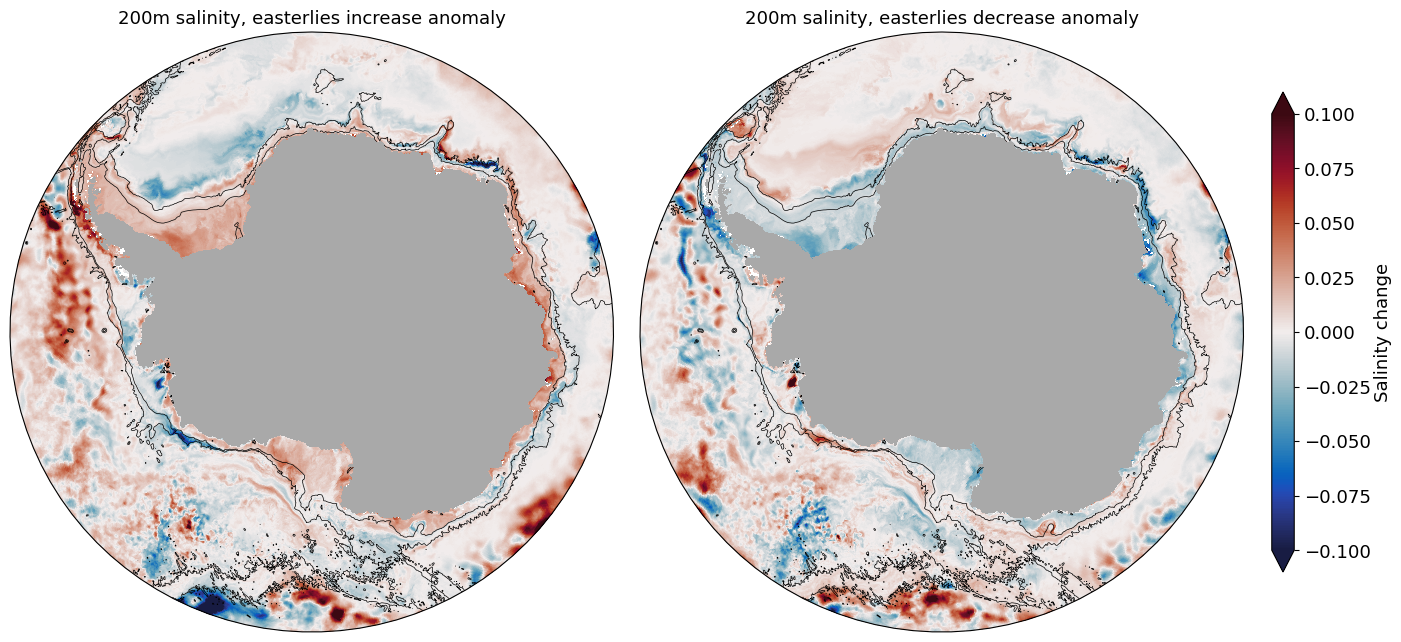

In [74]:
plot_land_etc(salt_con_slice,salt_up_slice,salt_down_slice,0.1)

## 500m maps

In [75]:
depth_slice = 500
depth_string = str(depth_slice)+'m'

salt_con = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con_slice = salt_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_con_slice = salt_con_slice.load()

salt_up = cc.querying.getvar(easterlies_up,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_up_slice = salt_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_up_slice = salt_up_slice.load()

salt_down = cc.querying.getvar(easterlies_down,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_down_slice = salt_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=depth_slice,method='nearest').mean('time')                             
salt_down_slice = salt_down_slice.load()

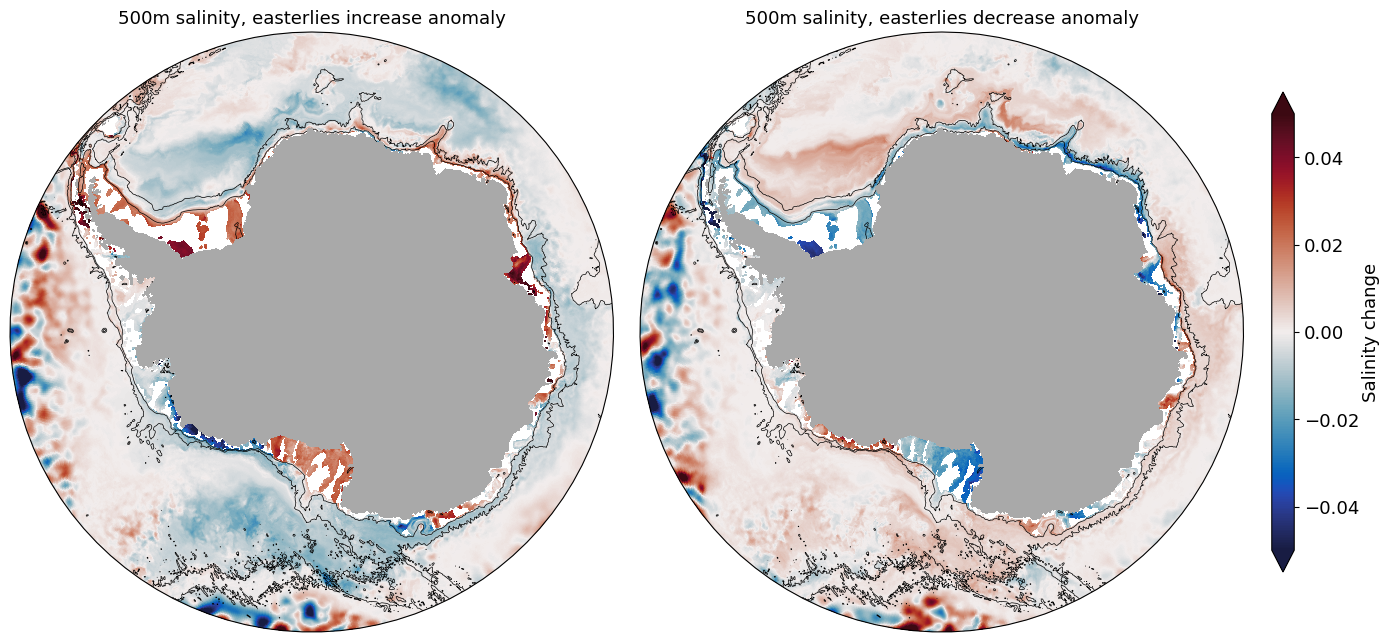

In [77]:
plot_land_etc(salt_con_slice,salt_up_slice,salt_down_slice,0.05)

## Bottom maps

In [78]:
depth_string = 'bottom'

salt_con = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

salt_up = cc.querying.getvar(easterlies_up,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_up = salt_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

salt_down = cc.querying.getvar(easterlies_down,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_down = salt_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

# select out bottom values:
depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

bottom_salt_up = salt_up.where(depth_array.st_ocean >= max_depth)
bottom_salt_up = bottom_salt_up.sum(dim = 'st_ocean')
bottom_salt_up = bottom_salt_up.load()

bottom_salt_down = salt_down.where(depth_array.st_ocean >= max_depth)
bottom_salt_down = bottom_salt_down.sum(dim = 'st_ocean')
bottom_salt_down = bottom_salt_down.load()

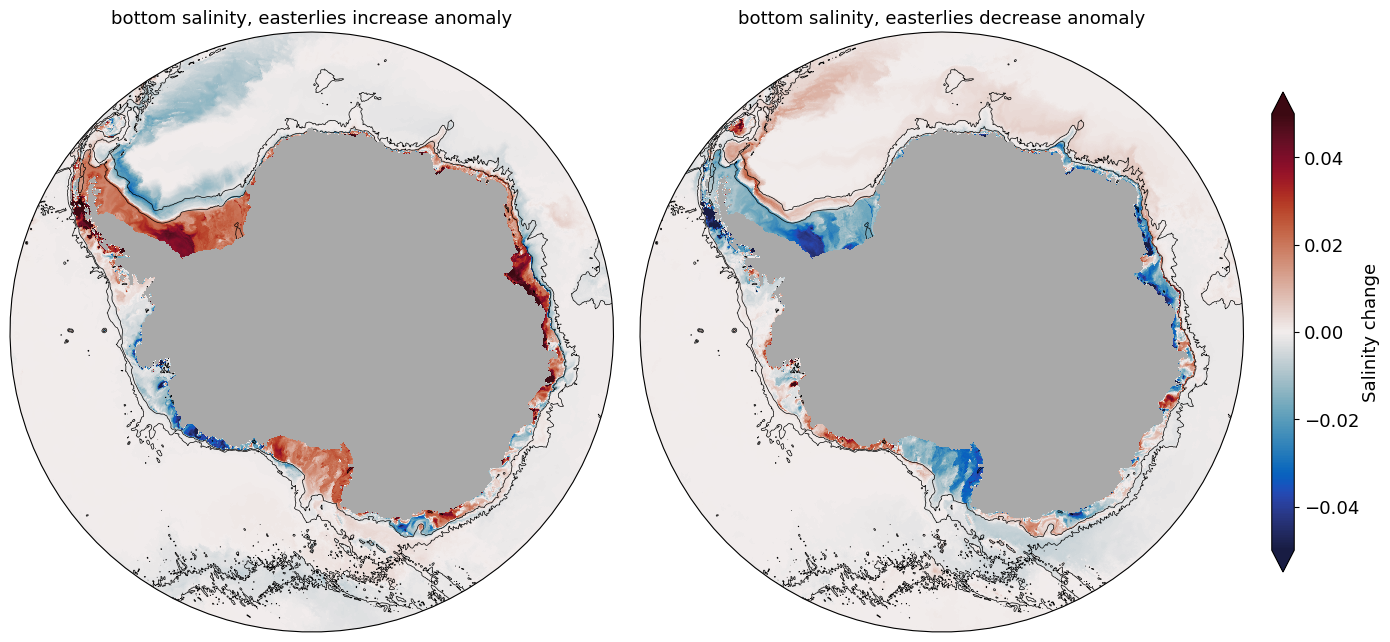

In [79]:
plot_land_etc(bottom_salt_con,bottom_salt_up,bottom_salt_down,0.05)

# Time series of bottom temperature on different sections of the shelf

## Amundsen Sea bottom temperature

In [91]:
# Do this one section at a time, otherwise will be too slow.
# Amundsen:
lon_slice  = slice(-140, -100)

# use whole time period:
start_time='2150-01-01'
end_time='2164-12-31'

In [92]:
depth_string = 'bottom'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice)

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice)                          

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice)                         

In [93]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
temp_con = temp_con * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_down = temp_down * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_up = temp_up * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [94]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_up = temp_up.where(depth_array.st_ocean >= max_depth)
bottom_temp_up = bottom_temp_up.sum(dim = 'st_ocean')
bottom_temp_up = bottom_temp_up.load()

bottom_temp_down = temp_down.where(depth_array.st_ocean >= max_depth)
bottom_temp_down = bottom_temp_down.sum(dim = 'st_ocean')
bottom_temp_down = bottom_temp_down.load()

In [95]:
# area weighting:
area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# apply to data and area weight:
bottom_temp_con = (bottom_temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
bottom_temp_con = bottom_temp_con.load()

bottom_temp_up = (bottom_temp_up*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
bottom_temp_up = bottom_temp_up.load()

bottom_temp_down = (bottom_temp_down*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
bottom_temp_down = bottom_temp_down.load()

Text(0.5, 1.0, 'Amundsen Sea bottom temperature')

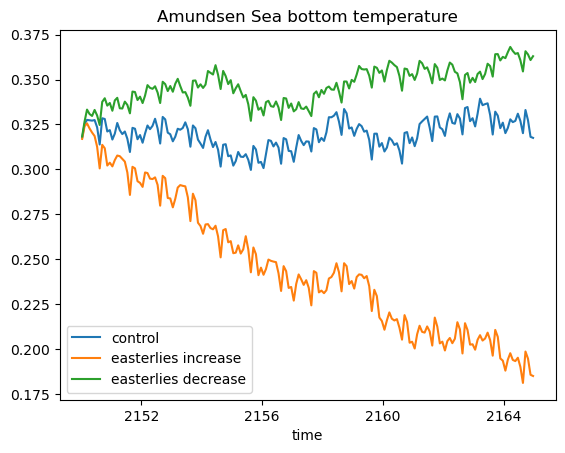

In [96]:
bottom_temp_con.plot(label='control')
bottom_temp_up.plot(label='easterlies increase')
bottom_temp_down.plot(label='easterlies decrease')
plt.legend()
plt.title('Amundsen Sea bottom temperature')

## Shelf surface temperature

In [7]:
# Do this one section at a time, otherwise will be too slow.
# whole shelf:
lon_slice  = slice(-280, 80)

# use whole time period:
start_time='2150-01-01'
end_time='2164-12-31'

In [16]:
depth_slice = 0
depth_string = str(depth_slice)+'m'

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')                          

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')                         

In [17]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
temp_con = temp_con * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_down = temp_down * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_up = temp_up * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [19]:
# area weighting:
area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# apply to data and area weight:
temp_con = (temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_con = temp_con.load()

temp_up = (temp_up*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_up = temp_up.load()

temp_down = (temp_down*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_down = temp_down.load()

Text(0.5, 0, 'Year')

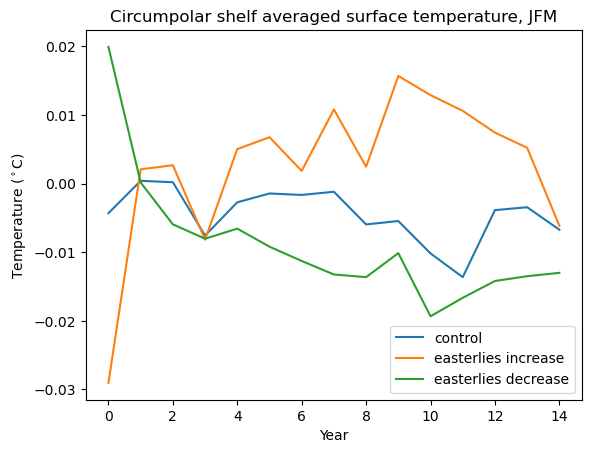

In [64]:
# plot seasonal means, because there is such a strong seasonal cycle and trend is much smaller than this:
temp_con_JFM = (31*temp_con[0::12].values + 28*temp_con[1::12].values + 31*temp_con[2::12].values)/(31+28+31)
temp_up_JFM = (31*temp_up[0::12].values + 28*temp_up[1::12].values + 31*temp_up[2::12].values)/(31+28+31)
temp_down_JFM = (31*temp_down[0::12].values + 28*temp_down[1::12].values + 31*temp_down[2::12].values)/(31+28+31)

plt.plot(temp_con_JFM,label='control')
plt.plot(temp_up_JFM,label='easterlies increase')
plt.plot(temp_down_JFM,label='easterlies decrease')
plt.legend()
plt.title('Circumpolar shelf averaged surface temperature, JFM')
plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

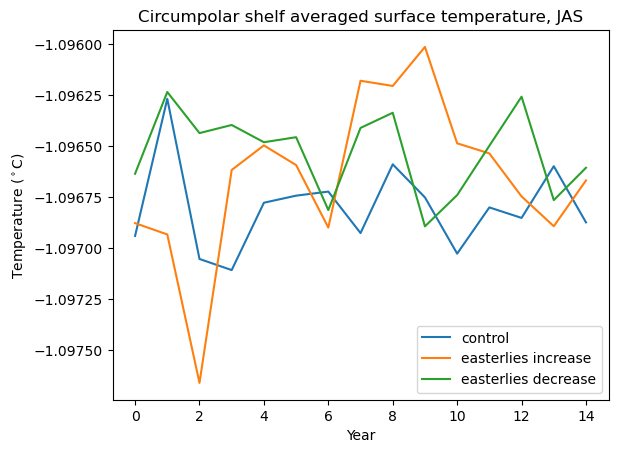

In [65]:
temp_con_JAS = (31*temp_con[6::12].values + 31*temp_con[7::12].values + 30*temp_con[8::12].values)/(31+31+30)
temp_up_JAS = (31*temp_up[6::12].values + 31*temp_up[7::12].values + 30*temp_up[8::12].values)/(31+31+30)
temp_down_JAS = (31*temp_down[6::12].values + 31*temp_down[7::12].values + 30*temp_down[8::12].values)/(31+31+30)

plt.plot(temp_con_JAS,label='control')
plt.plot(temp_up_JAS,label='easterlies increase')
plt.plot(temp_down_JAS,label='easterlies decrease')
plt.legend()
plt.title('Circumpolar shelf averaged surface temperature, JAS')
plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Year')